# Deep Learning Lab Assignment 2

    Ayush Abrol B20AI052

---

In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [375]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline

In [376]:
import warnings
warnings.filterwarnings('ignore')

In [377]:
# Roll Number = B20AI052
# X = 5 
# Y = "relu"

In [378]:
# Loading the MNIST dataset
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data/mnist', train=True, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data/mnist', train=False, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

In [379]:
# Printing the shape of the training data
print("Train data shape: ", train_loader.dataset.train_data.shape)
print("Test data shape: ", test_loader.dataset.test_data.shape)

print("Train labels shape: ", train_loader.dataset.train_labels.shape)
print("Test labels shape: ", test_loader.dataset.test_labels.shape)

Train data shape:  torch.Size([60000, 28, 28])
Test data shape:  torch.Size([10000, 28, 28])
Train labels shape:  torch.Size([60000])
Test labels shape:  torch.Size([10000])


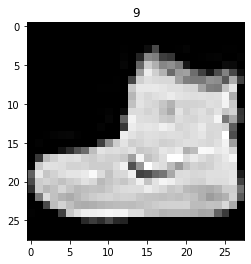

In [380]:
plt.imshow(train_loader.dataset.train_data[0].numpy())
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

In [381]:
for data in train_loader:
    print(data[0].shape)
    print(data[1].shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [382]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [383]:
# Adding noise to the images
def add_noise(image):
    noise = (torch.randn(image.size()) * 0.2) # Adding noise with weightage of 20%
    noisy_image = (image + noise)
    return noisy_image

In [384]:
# Creating a noisy dataset
noisy_train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data/mnist', train=True, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)
noisy_test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data/mnist', train=False, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

# Adding noise to the images
for data in noisy_train_loader:
    noisy_data = add_noise(data[0])
    noisy_labels = data[1]

for data in noisy_test_loader:
    noisy_test_data = add_noise(data[0])
    noisy_test_labels = data[1]

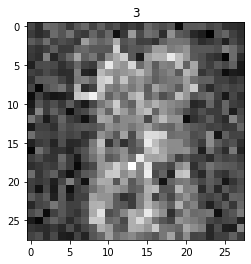

In [385]:
# Plot the noisy images
plt.imshow(noisy_data[0].numpy().reshape(28, 28))
plt.title('%i' % noisy_labels[0])
plt.show()

In [386]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, activation_function, input_size, output_size): # input_size = 784, output_size = 32
        super(DenoisingAutoEncoder, self).__init__() # Initializing the parent class
        self.encoder = nn.Sequential( # Encoder 
            nn.Linear(input_size, int(input_size/2)), # 784 -> 392
            activation_function, # Activation function 
            nn.Linear(int(input_size/2), int(input_size/4)), # 392 -> 196
            activation_function, 
            nn.Linear(int(input_size/4), int(input_size/8)), # 196 -> 98
            activation_function, 
            nn.Linear(int(input_size/8), int(input_size/16)), # 98 -> 49
            activation_function,
            nn.Linear(int(input_size/16), output_size), # 49 -> 128
            activation_function,
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_size, int(input_size/16)), # 128 -> 49
            activation_function,
            nn.Linear(int(input_size/16), int(input_size/8)), # 49 -> 98
            activation_function,
            nn.Linear(int(input_size/8), int(input_size/4)), # 98 -> 196
            activation_function,
            nn.Linear(int(input_size/4), int(input_size/2)), # 196 -> 392
            activation_function,
            nn.Linear(int(input_size/2), input_size), # 392 -> 784
            activation_function,
        )
    def encoder_func(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoder_func(self, x):
        decoded = self.decoder(x)
        return decoded

    def forward(self, x):
        encoded_layer = self.encoder(x)
        decoded_layer = self.decoder(encoded_layer)
        return decoded_layer

In [387]:
class FullyConnectedLayers(nn.Module):
    def __init__(self, activation_function, num_fc_layers, input_size, output_classes): # input_size = 32, output_classes = 10
        super(FullyConnectedLayers, self).__init__() 
        self.num_fc_layers = num_fc_layers # Number of fully connected layers
        self.fc_layers = nn.Sequential() # Fully connected layers
        for i in range(self.num_fc_layers): # Adding fully connected layers
            if i == 0:
                self.fc_layers.add_module("fc_layer_{}".format(i), nn.Linear(input_size, int(input_size/2))) 
            else:
                self.fc_layers.add_module("fc_layer_{}".format(i), nn.Linear(int(input_size/2), int(input_size/2))) 
            self.fc_layers.add_module("activation_{}".format(i), activation_function)
        self.fc_layers.add_module("fc_layer_{}".format(self.num_fc_layers), nn.Linear(int(input_size/2), output_classes))
        torch.nn.Softmax() # Softmax activation function
    def forward(self, x):
        output = self.fc_layers(x)
        return output

In [388]:
model = (DenoisingAutoEncoder(nn.ReLU(), 784, 128)).to(device) # 784 = 28*28
loss_function = nn.MSELoss().to(device) # Mean Squared Error 
optimizer = optim.Adam(model.parameters(), lr=1e-2) # Learning rate = 0.01

In [389]:
def train(model,epoch, training_losses):
    model.train()  # Setting the model to training mode
    train_loss = 0 # Initializing the loss to 0
    for batch_idx, (img, _) in enumerate(train_loader): # Iterating through the training set
        img = img.reshape(-1, 784)  # Reshaping the image to a vector of size 784
        data = img + 0.2*torch.randn(img.shape) # Adding noise of weightage 20% to the image
        data = data.to(device) # Sending the data to the GPU
        optimizer.zero_grad() 
        recon_batch = model(data) # Reconstructing the image
        loss = loss_function(recon_batch, img.to(device)) # Loss is calculated between the original image and the reconstructed image
        loss.backward() # Backpropagation
        train_loss += loss.item() # Calculating the loss
        optimizer.step() # Updating the weights
        if batch_idx % 1000 == 0:  
            print('Train Epoch: {} \tLoss: {:.6f}'.format( 
                epoch, loss.item() / len(data))) # Printing the loss for each batch

    print('====> Epoch: {} Average loss: {:.4f}'.format( 
          epoch, train_loss / len(train_loader.dataset))) # Printing the average loss for each epoch
    training_losses.append(train_loss / len(train_loader.dataset)) # Saving the average loss for each epoch

def test(model,epoch, testing_losses):
    model.eval() # Setting the model to evaluation mode
    test_loss = 0 # Initializing the loss to 0
    with torch.no_grad(): # We don't need to calculate the gradients for the test set
        for i, (data, _) in enumerate(test_loader): # Iterating through the test set
            data = data.reshape(-1, 784) # Reshaping the image to a vector of size 784
            data = data + 0.2*torch.randn(data.shape) # Adding noise of weightage 20% to the image
            data = data.to(device) # Sending the data to the GPU
            recon_batch = model(data) # Reconstructing the image
            test_loss += loss_function(recon_batch, data).item() # Calculating the loss
            if i == 0: # Saving the first image of the test set
                n = min(data.size(0), 8) # Number of images to be displayed
                comparison = torch.cat([data.view(128, 1, 28, 28)[:n],recon_batch.view(128, 1, 28, 28)[:n]]) # Concatenating the original and reconstructed images
                save_image(comparison.cpu(), 'results/Only_Reconstructing/reconstruction_' + str(epoch) + '.png', nrow=n) # Saving the image

    test_loss /= len(test_loader.dataset)
    testing_losses.append(test_loss) # Saving the average loss for each epoch
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [390]:
epochs = 10
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train(model,epoch, train_losses)
    test(model,epoch, test_losses)

Train Epoch: 1 	Loss: 0.001417
====> Epoch: 1 Average loss: 0.0006
====> Test set loss: 0.0008
Train Epoch: 2 	Loss: 0.000519
====> Epoch: 2 Average loss: 0.0005
====> Test set loss: 0.0007
Train Epoch: 3 	Loss: 0.000447
====> Epoch: 3 Average loss: 0.0004
====> Test set loss: 0.0007
Train Epoch: 4 	Loss: 0.000389
====> Epoch: 4 Average loss: 0.0004
====> Test set loss: 0.0007
Train Epoch: 5 	Loss: 0.000402
====> Epoch: 5 Average loss: 0.0004
====> Test set loss: 0.0007
Train Epoch: 6 	Loss: 0.000357
====> Epoch: 6 Average loss: 0.0004
====> Test set loss: 0.0007
Train Epoch: 7 	Loss: 0.000338
====> Epoch: 7 Average loss: 0.0004
====> Test set loss: 0.0007
Train Epoch: 8 	Loss: 0.000312
====> Epoch: 8 Average loss: 0.0003
====> Test set loss: 0.0006
Train Epoch: 9 	Loss: 0.000319
====> Epoch: 9 Average loss: 0.0003
====> Test set loss: 0.0006
Train Epoch: 10 	Loss: 0.000301
====> Epoch: 10 Average loss: 0.0003
====> Test set loss: 0.0006


### Following are the plots between the noisy images and the reconstructed images without classifying the images

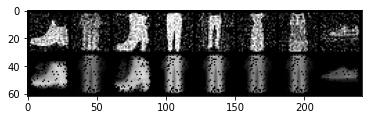

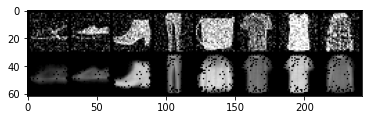

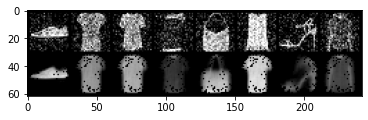

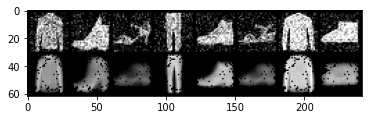

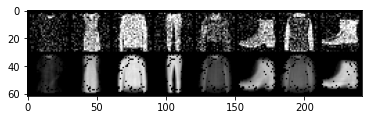

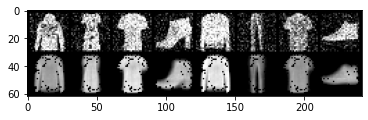

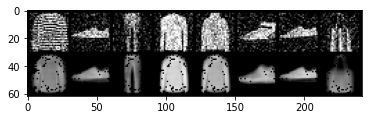

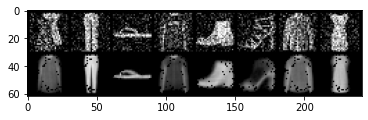

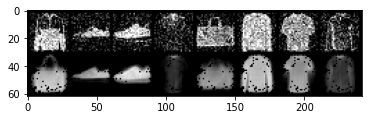

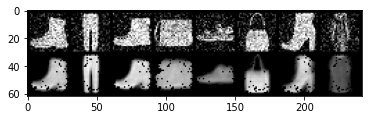

In [391]:
# Plotting the reconstructed images from results directory separately
from PIL import Image

def plot_reconstructed_images():
    for i in range(1, 11):
        img = Image.open('results/Only_Reconstructing/reconstruction_' + str(i) + '.png')
        plt.imshow(img)
        plt.show()

plot_reconstructed_images()

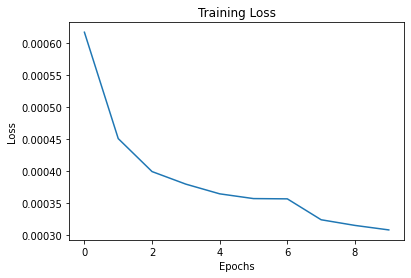

In [392]:
# Plotting the training loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

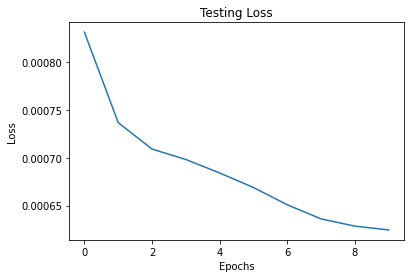

In [393]:
# Plotting the testing loss
plt.plot(test_losses)
plt.title("Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [394]:
print("Training Losses for the Denoising Autoencoder: ", train_losses)
print()
print("Testing Losses for the Denoising Autoencoder:", test_losses)

Training Losses for the Denoising Autoencoder:  [0.000616951098665595, 0.00045108108228693403, 0.00039964994142452874, 0.0003800426693012317, 0.000364939956056575, 0.000357527007907629, 0.0003571143883590897, 0.00032450915798544884, 0.00031569029813011487, 0.0003086718033378323]

Testing Losses for the Denoising Autoencoder: [0.0008309813261032105, 0.0007365641988813877, 0.0007089872233569622, 0.0006980779580771923, 0.0006840121649205684, 0.0006688306741416454, 0.0006507903546094894, 0.0006360585272312165, 0.0006284723833203316, 0.0006245612151920796]


In [395]:
def train_classify(model,epoch, model_classifier, optimizer, loss_function, training_losses, images):
    model.train() # Setting the model to training mode
    train_loss = 0 # Initializing the loss to 0
    for batch_idx, (img, label) in enumerate(train_loader): # Iterating through the training set
        img = img.reshape(-1, 784) # Reshaping the image to a vector of size 784
        data = img + 0.2*torch.randn(img.shape) # Adding noise of weightage 20% to the image
        data = data.to(device) # Sending the data to the GPU
        optimizer.zero_grad() 
        encoded_layer = model.encoder_func(data) # Encoding the image
        output = model_classifier(encoded_layer) # Performing the classification task
        loss = loss_function(output, label.to(device)) # Calculating the loss
        loss.backward() # Backpropagation
        train_loss += loss.item() # Calculating the loss
        optimizer.step() # Updating the weights
        
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format( 
                epoch, loss.item() / len(data))) # Printing the loss for each batch   
    print('====> Epoch: {} Average loss: {:.4f}'.format( 
          epoch, train_loss / len(train_loader.dataset))) # Printing the average loss for each epoch
    training_losses.append(train_loss / len(train_loader.dataset)) # Saving the average loss for each epoch


def test_classify(model,epoch, model_classifier, loss_function, testing_losses, testing_accuracies, images):
    model.eval() # Setting the model to evaluation mode
    test_loss = 0 # Initializing the loss to 0
    correct = 0 # Initializing the correct predictions to 0
    with torch.no_grad(): # We don't need to calculate the gradients for the test set
        for i, (data, label) in enumerate(test_loader): # Iterating through the test set
            data = data.reshape(-1, 784) # Reshaping the image to a vector of size 784
            data = data + 0.2*torch.randn(data.shape)
            data = data.to(device) # Sending the data to the GPU
            encoded_layer = model.encoder_func(data) # Encoding the image
            output = model_classifier(encoded_layer) # Performing the classification task
            test_loss += loss_function(output, label.to(device)).item() # Calculating the loss
            pred = output.max(1, keepdim=True)[1] # Getting the index of the max log-probability
            correct += pred.eq(label.to(device).view_as(pred)).sum().item() # Calculating the number of correct predictions
            # Appening the first 1000 images of the test set for tsne visualization
            if i == 0:
                images.append(encoded_layer)
            # Saving first 10 images of the test set
            if i == 0:
                n = min(data.size(0), 10)
                comparison = torch.cat([data.view(128, 1, 28, 28)[:n],model.decoder_func(encoded_layer).view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), 'results/FC_' + str(model_classifier.num_fc_layers) + '/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> Test set accuracy: {}/{} ({:.0f}%)'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    testing_losses.append(test_loss) # Saving the average loss for each epoch
    testing_accuracies.append(100. * correct / len(test_loader.dataset)) # Saving the accuracy for each epoch

### Using 1 Fully Connected Layer for 10 class classification with ReLU activation.

In [396]:
# Performing the classification task with 1 Fully Connected Layer
model_classifier_1 = (FullyConnectedLayers(nn.ReLU(), 1, 128, 10)).to(device) 
loss_function = nn.CrossEntropyLoss().to(device) # Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-2) # Learning rate = 0.01

epochs = 10
train_losses_1 = []
test_losses_1 = []
test_accuracies_1 = []
images_1 = []
for epoch in range(1, epochs + 1):
    train_classify(model,epoch, model_classifier_1, optimizer, loss_function, train_losses_1, images_1)
    test_classify(model,epoch, model_classifier_1, loss_function, test_losses_1, test_accuracies_1, images_1)

Train Epoch: 1 	Loss: 0.018432
====> Epoch: 1 Average loss: 0.0068
====> Test set loss: 0.0050
====> Test set accuracy: 7688/10000 (77%)
Train Epoch: 2 	Loss: 0.004533
====> Epoch: 2 Average loss: 0.0045
====> Test set loss: 0.0046
====> Test set accuracy: 7827/10000 (78%)
Train Epoch: 3 	Loss: 0.004458
====> Epoch: 3 Average loss: 0.0042
====> Test set loss: 0.0042
====> Test set accuracy: 8064/10000 (81%)
Train Epoch: 4 	Loss: 0.002751
====> Epoch: 4 Average loss: 0.0040
====> Test set loss: 0.0043
====> Test set accuracy: 8033/10000 (80%)
Train Epoch: 5 	Loss: 0.003771
====> Epoch: 5 Average loss: 0.0038
====> Test set loss: 0.0040
====> Test set accuracy: 8176/10000 (82%)
Train Epoch: 6 	Loss: 0.003756
====> Epoch: 6 Average loss: 0.0037
====> Test set loss: 0.0040
====> Test set accuracy: 8165/10000 (82%)
Train Epoch: 7 	Loss: 0.003759
====> Epoch: 7 Average loss: 0.0036
====> Test set loss: 0.0040
====> Test set accuracy: 8154/10000 (82%)
Train Epoch: 8 	Loss: 0.004241
====> Epoc

In [398]:
images_1 = torch.cat(images_1).cpu().detach().numpy()
images_1.shape

(1280, 128)

In [399]:
print("Training Losses for the Denoising Autoencoder with 1 Fully Connected Layer: \n", train_losses_1)
print()
print("Testing Losses for the Denoising Autoencoder with 1 Fully Connected Layer: \n", test_losses_1)
print()
print("Testing Accuracies for the Denoising Autoencoder with 1 Fully Connected Layer: \n", test_accuracies_1)

Training Losses for the Denoising Autoencoder with 1 Fully Connected Layer: 
 [0.006759525946279367, 0.004526865595082442, 0.004201940633853277, 0.003970088193317255, 0.0038464481125275295, 0.003749655970931053, 0.0036417193000515304, 0.0036084072237213454, 0.0034902456718186536, 0.00345338455910484]

Testing Losses for the Denoising Autoencoder with 1 Fully Connected Layer: 
 [0.004973447433114052, 0.0046030539214611055, 0.004246079170703888, 0.004290855094790459, 0.003990874770283699, 0.003985476483404637, 0.004005363884568214, 0.00386362042427063, 0.003911189746856689, 0.003918801636248827]

Testing Accuracies for the Denoising Autoencoder with 1 Fully Connected Layer: 
 [76.88, 78.27, 80.64, 80.33, 81.76, 81.65, 81.54, 82.28, 82.39, 82.71]


### Using 3 Fully Connected Layers for 10 class classification with ReLU activation.

In [400]:
model_classsifier_3 = (FullyConnectedLayers(nn.ReLU(), 3, 128, 10)).to(device) # Performing the classification task with 3 Fully Connected Layers
loss_function = nn.CrossEntropyLoss().to(device) # Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-2) # Learning rate = 0.01

epochs = 10
train_losses_3 = []
test_losses_3 = []
test_accuracies_3 = []
images_3 = []
for epoch in range(1, epochs + 1):
    train_classify(model,epoch, model_classsifier_3, optimizer, loss_function, train_losses_3, images_3)
    test_classify(model,epoch, model_classsifier_3, loss_function, test_losses_3, test_accuracies_3, images_3)

Train Epoch: 1 	Loss: 0.023385
====> Epoch: 1 Average loss: 0.0066
====> Test set loss: 0.0051
====> Test set accuracy: 7417/10000 (74%)
Train Epoch: 2 	Loss: 0.005255
====> Epoch: 2 Average loss: 0.0038
====> Test set loss: 0.0039
====> Test set accuracy: 8313/10000 (83%)
Train Epoch: 3 	Loss: 0.003121
====> Epoch: 3 Average loss: 0.0035
====> Test set loss: 0.0038
====> Test set accuracy: 8291/10000 (83%)
Train Epoch: 4 	Loss: 0.003138
====> Epoch: 4 Average loss: 0.0034
====> Test set loss: 0.0038
====> Test set accuracy: 8385/10000 (84%)
Train Epoch: 5 	Loss: 0.002752
====> Epoch: 5 Average loss: 0.0033
====> Test set loss: 0.0038
====> Test set accuracy: 8300/10000 (83%)
Train Epoch: 6 	Loss: 0.002564
====> Epoch: 6 Average loss: 0.0033
====> Test set loss: 0.0037
====> Test set accuracy: 8369/10000 (84%)
Train Epoch: 7 	Loss: 0.003489
====> Epoch: 7 Average loss: 0.0032
====> Test set loss: 0.0036
====> Test set accuracy: 8375/10000 (84%)
Train Epoch: 8 	Loss: 0.003898
====> Epoc

In [420]:
images_3 = torch.cat(images_3).cpu().detach().numpy()
images_3.shape

(1280, 128)

In [421]:
def plot_classified_images(num_fc_layers):
    for i in range(1, 11):
        img = Image.open('results/FC_'+str(num_fc_layers)+'/reconstruction_' + str(i) + '.png')
        plt.imshow(img)
        plt.show()

### Displaying the first 10 images of the test set and their reconstruction using the 1FC layer model.

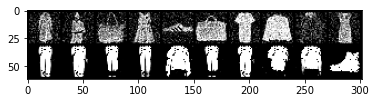

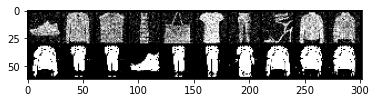

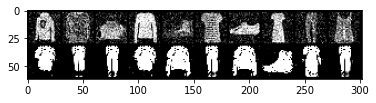

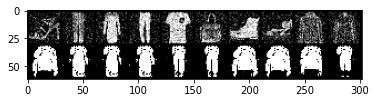

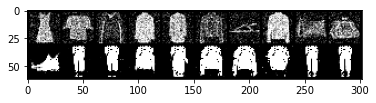

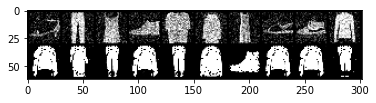

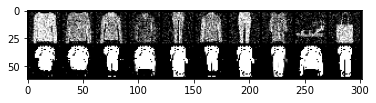

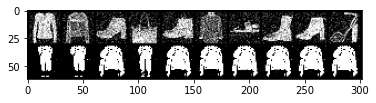

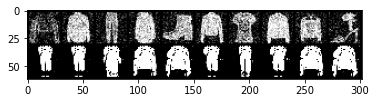

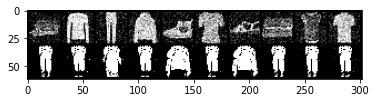

In [422]:
plot_classified_images(1)

### Displaying the first 10 images of the test set and their reconstruction using the 3FC layer model.

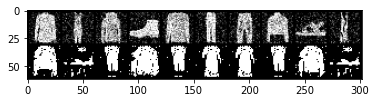

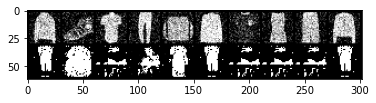

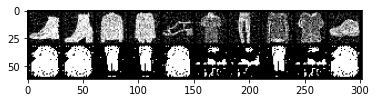

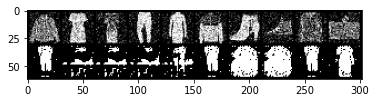

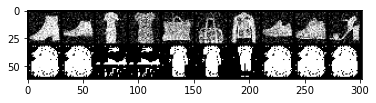

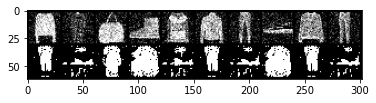

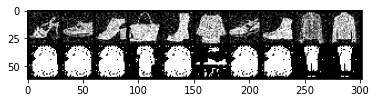

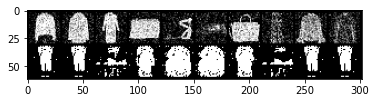

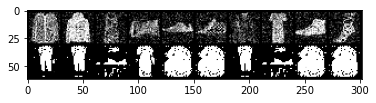

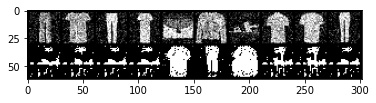

In [423]:
plot_classified_images(3)

### Loss curves for 1 Fully Connected Layer for 10 class classification (Training and Testing)

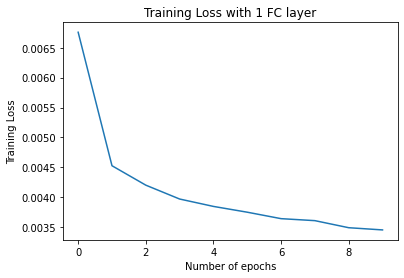

In [424]:
# Plot for training loss with 1 FC layer with respect to the number of epochs
plt.plot(train_losses_1)
plt.title('Training Loss with 1 FC layer')
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.show()

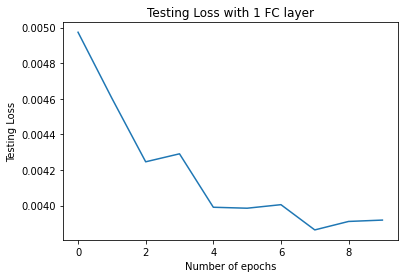

In [425]:
# Plot for testing loss with 1 FC layer with respect to the number of epochs
plt.plot(test_losses_1)
plt.title('Testing Loss with 1 FC layer')
plt.xlabel('Number of epochs')
plt.ylabel('Testing Loss')
plt.show()

### Accuracy curve for 1 Fully Connected Layer for 10 class classification.

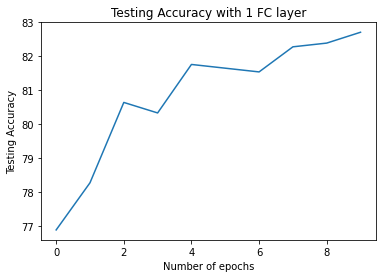

In [426]:
# Plot for testing accuracy with 1 FC layer with respect to the number of epochs
plt.plot(test_accuracies_1)
plt.title('Testing Accuracy with 1 FC layer')
plt.xlabel('Number of epochs')
plt.ylabel('Testing Accuracy')
plt.show()

### Loss curves for 3 Fully Connected Layers for 10 class classification (Training and Testing Both)

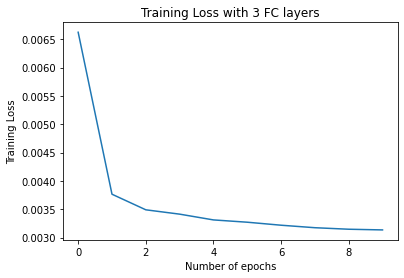

In [427]:
# Plot for training loss with 3 FC layers with respect to the number of epochs
plt.plot(train_losses_3)
plt.title('Training Loss with 3 FC layers')
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.show()

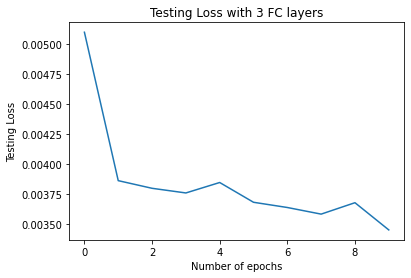

In [428]:
# Plot for testing loss with 3 FC layers with respect to the number of epochs
plt.plot(test_losses_3)
plt.title('Testing Loss with 3 FC layers')
plt.xlabel('Number of epochs')
plt.ylabel('Testing Loss')
plt.show()

### Accuracy curve for 3 Fully Connected Layers for 10 class classification.

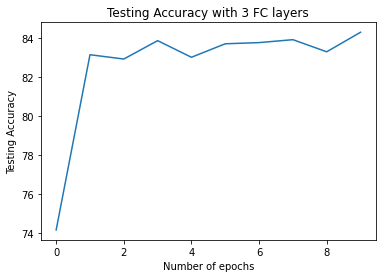

In [429]:
# Plot for testing accuracy with 3 FC layers with respect to the number of epochs
plt.plot(test_accuracies_3)
plt.title('Testing Accuracy with 3 FC layers')
plt.xlabel('Number of epochs')
plt.ylabel('Testing Accuracy')
plt.show()

### Comparison between the losses of 1FC and 3FC models

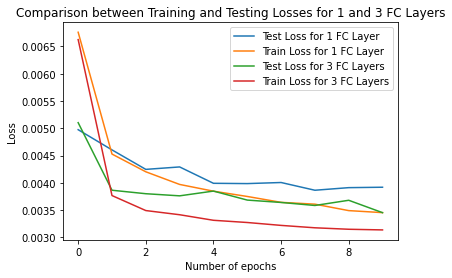

In [430]:
plt.plot(test_losses_1, label='Test Loss for 1 FC Layer')
plt.plot(train_losses_1, label='Train Loss for 1 FC Layer')
plt.plot(test_losses_3, label='Test Loss for 3 FC Layers')
plt.plot(train_losses_3, label='Train Loss for 3 FC Layers')
plt.title('Comparison between Training and Testing Losses for 1 and 3 FC Layers')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparison between the accuracies of 1FC and 3FC models

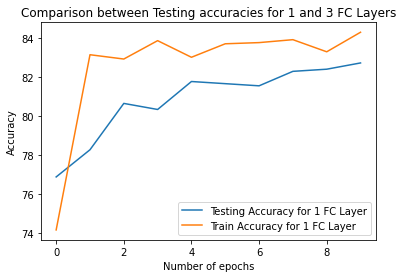

In [431]:
plt.plot(test_accuracies_1, label='Testing Accuracy for 1 FC Layer')
plt.plot(test_accuracies_3, label='Train Accuracy for 1 FC Layer')
plt.title('Comparison between Testing accuracies for 1 and 3 FC Layers')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### t-SNE plot

In [432]:
from sklearn.manifold import TSNE

In [445]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_loader:
    embed = model.encoder_func(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break

lt_embed = torch.cat(lt_embed).cpu().detach().numpy()
lt_lb = torch.cat(lt_lb).cpu().detach().numpy()

In [446]:
lt_embed.shape

(1024, 128)

In [448]:
lt_lb

array([4, 0, 2, ..., 3, 2, 7], dtype=int64)

In [450]:
tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(lt_embed)

In [451]:
tsne_data.shape

(1024, 2)

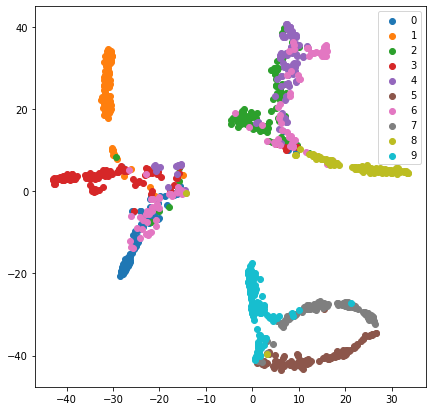

In [452]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = lt_lb

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

___